# IMDB Dataset of 50K Movie Reviews

https://www.kaggle.com/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews

In [3]:
import pandas as pd

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction import text

from sklearn.pipeline import Pipeline

import string

In [4]:
f = "data/IMDB Dataset.csv"
df = pd.read_csv(f)

ratings = {'positive': 1, 'negative': 0}
df['sentiment'] = df['sentiment'].replace(ratings)
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1


In [5]:
df.shape

(50000, 2)

In [6]:
# balanced classes
df['sentiment'].value_counts()

0    25000
1    25000
Name: sentiment, dtype: int64

In [7]:
remove_chars = ["£", "«",  "»",  "–",  "’",  "“", "”"]

stopwords = text.ENGLISH_STOP_WORDS

def preprocess(doc):
    doc = doc.replace("<br />", " ")
    doc = "".join([char for char in doc if char not in string.punctuation and not char.isdigit() and char not in remove_chars])
    doc = " ".join([token.lower() for token in doc.split() if token not in stopwords])
    return doc

In [8]:
# Split into train, validate, test sets
X = df['review']
y = df['sentiment']

# hold out 20% of data for testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=0)

print(f"Train:      {X_train.shape, y_train.shape}")
print(f"Test        {X_test.shape, y_test.shape}")

Train:      ((40000,), (40000,))
Test        ((10000,), (10000,))


# Model Selection

In [9]:
# from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier

In [10]:
pipeline = Pipeline([
    ('vectorize', TfidfVectorizer(preprocessor=preprocess)),
    ('clf',None),
])

In [12]:
search_space = [
    {"clf": [LogisticRegression()]},
    {"clf": [MultinomialNB()]},
    {"clf": [LinearSVC()]},
    {"clf": [RandomForestClassifier()], 'clf__max_depth': [10]}
    
]

grid_search = GridSearchCV(pipeline, search_space, cv=3, verbose=1, scoring='accuracy')

In [13]:
%%time
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 4 candidates, totalling 12 fits
CPU times: user 4min 2s, sys: 1.92 s, total: 4min 4s
Wall time: 4min 1s


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('vectorize',
                                        TfidfVectorizer(preprocessor=<function preprocess at 0x7f901447b430>)),
                                       ('clf', None)]),
             param_grid=[{'clf': [LogisticRegression()]},
                         {'clf': [MultinomialNB()]}, {'clf': [LinearSVC()]},
                         {'clf': [RandomForestClassifier()],
                          'clf__max_depth': [10]}],
             scoring='accuracy', verbose=1)

In [11]:
pd.DataFrame(grid_search.cv_results_).sort_values('rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_clf,param_clf__max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
2,16.118946,0.791819,3.835284,0.151234,LinearSVC(),NaN,{'clf': LinearSVC()},0.896500,0.896000,0.888500,0.889000,0.894375,0.892875,0.003444,1
0,18.916425,1.041195,4.048282,0.223297,LogisticRegression(),NaN,{'clf': LogisticRegression()},0.895125,0.892125,0.889625,0.888125,0.894875,0.891975,0.002782,2
1,16.852530,1.716631,3.869602,0.085778,MultinomialNB(),NaN,{'clf': MultinomialNB()},0.869375,0.856750,0.862750,0.859125,0.869625,0.863525,0.005240,3
3,17.905089,0.896245,4.178711,0.119135,RandomForestClassifier(),10,"{'clf': RandomForestClassifier(), 'clf__max_de...",0.826875,0.816125,0.831625,0.815500,0.828500,0.823725,0.006641,4


# Parameter Selection

In [11]:
parameters = {
    'vectorize__max_features': [10000],
    'vectorize__ngram_range': [(1, 1), (1, 2)],
    'clf':  [LogisticRegression()],
    'clf__penalty': ['l1', 'l2'],
    'clf__C': [1, 10],
    'clf__solver': ['liblinear']
}

lr_clf = GridSearchCV(pipeline, parameters, verbose=3, cv=3,refit=False, scoring='accuracy')

In [12]:
%%time
lr_clf.fit(X_train, y_train)

Fitting 3 folds for each of 8 candidates, totalling 24 fits
[CV 1/3] END clf=LogisticRegression(), clf__C=1, clf__penalty=l1, clf__solver=liblinear, vectorize__max_features=10000, vectorize__ngram_range=(1, 1);, score=0.877 total time=  19.5s
[CV 2/3] END clf=LogisticRegression(), clf__C=1, clf__penalty=l1, clf__solver=liblinear, vectorize__max_features=10000, vectorize__ngram_range=(1, 1);, score=0.874 total time=  23.1s
[CV 3/3] END clf=LogisticRegression(), clf__C=1, clf__penalty=l1, clf__solver=liblinear, vectorize__max_features=10000, vectorize__ngram_range=(1, 1);, score=0.879 total time=  21.0s
[CV 1/3] END clf=LogisticRegression(), clf__C=1, clf__penalty=l1, clf__solver=liblinear, vectorize__max_features=10000, vectorize__ngram_range=(1, 2);, score=0.878 total time=  35.5s
[CV 2/3] END clf=LogisticRegression(), clf__C=1, clf__penalty=l1, clf__solver=liblinear, vectorize__max_features=10000, vectorize__ngram_range=(1, 2);, score=0.876 total time=  36.8s
[CV 3/3] END clf=Logistic

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('vectorize',
                                        TfidfVectorizer(preprocessor=<function preprocess at 0x7fc9d645adc0>)),
                                       ('clf', None)]),
             param_grid={'clf': [LogisticRegression()], 'clf__C': [1, 10],
                         'clf__penalty': ['l1', 'l2'],
                         'clf__solver': ['liblinear'],
                         'vectorize__max_features': [10000],
                         'vectorize__ngram_range': [(1, 1), (1, 2)]},
             refit=False, scoring='accuracy', verbose=3)

In [13]:
pd.DataFrame(lr_clf.cv_results_).sort_values('rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_clf,param_clf__C,param_clf__penalty,param_clf__solver,param_vectorize__max_features,param_vectorize__ngram_range,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
3,22.726697,0.253809,6.618079,0.023526,LogisticRegression(),1,l2,liblinear,10000,"(1, 2)","{'clf': LogisticRegression(), 'clf__C': 1, 'cl...",0.892230,0.885922,0.889447,0.889200,0.002581,1
2,12.148531,0.145682,5.706790,0.054732,LogisticRegression(),1,l2,liblinear,10000,"(1, 1)","{'clf': LogisticRegression(), 'clf__C': 1, 'cl...",0.890580,0.883747,0.888322,0.887550,0.002843,2
7,23.514667,0.844645,6.624786,0.012053,LogisticRegression(),10,l2,liblinear,10000,"(1, 2)","{'clf': LogisticRegression(), 'clf__C': 10, 'c...",0.887731,0.879097,0.883597,0.883475,0.003526,3
6,12.623377,0.509415,6.223050,0.759345,LogisticRegression(),10,l2,liblinear,10000,"(1, 1)","{'clf': LogisticRegression(), 'clf__C': 10, 'c...",0.884956,0.878497,0.882772,0.882075,0.002682,4
1,27.784841,1.172956,7.472712,0.256040,LogisticRegression(),1,l1,liblinear,10000,"(1, 2)","{'clf': LogisticRegression(), 'clf__C': 1, 'cl...",0.877756,0.875722,0.878872,0.877450,0.001304,5
0,14.025983,0.674095,7.188775,0.998675,LogisticRegression(),1,l1,liblinear,10000,"(1, 1)","{'clf': LogisticRegression(), 'clf__C': 1, 'cl...",0.876856,0.874072,0.879097,0.876675,0.002055,6
5,23.836415,0.079054,6.614490,0.019602,LogisticRegression(),10,l1,liblinear,10000,"(1, 2)","{'clf': LogisticRegression(), 'clf__C': 10, 'c...",0.868832,0.862897,0.868672,0.866800,0.002761,7
4,12.926028,0.280068,5.767296,0.131539,LogisticRegression(),10,l1,liblinear,10000,"(1, 1)","{'clf': LogisticRegression(), 'clf__C': 10, 'c...",0.866432,0.858396,0.866122,0.863650,0.003717,8


# Test Score

In [14]:
# selected_params = lr_clf.cv_results_['params'][1]
selected_params = lr_clf.best_params_
pipeline.set_params(**selected_params)

Pipeline(steps=[('vectorize',
                 TfidfVectorizer(max_features=10000, ngram_range=(1, 2),
                                 preprocessor=<function preprocess at 0x7fc9d645adc0>)),
                ('clf', LogisticRegression(C=1, solver='liblinear'))])

In [15]:
%%time
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
evaluate(y_test, y_pred)

              precision    recall  f1-score   support

           0       0.90      0.88      0.89      5035
           1       0.88      0.90      0.89      4965

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000

confusion matrix:
[[4455  580]
 [ 518 4447]]
CPU times: user 39.5 s, sys: 722 ms, total: 40.2 s
Wall time: 39.6 s


In [25]:
print(f'Accuracy Score: {pipeline.score(X_test, y_test)}')

Accuracy Score: 0.8902


In [16]:
vect = pipeline['vectorize']
print(len(vect.get_feature_names()))
print(len(vect.stop_words_))


10000
2750751


# Confusion Matrix

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

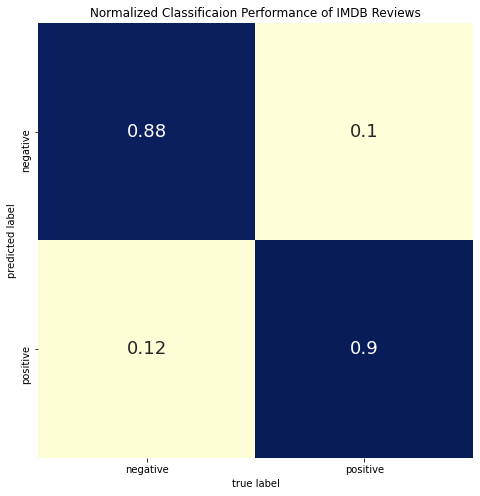

In [18]:
fig_dims = (8, 8)
fig, ax = plt.subplots(figsize=fig_dims)

cm = confusion_matrix(y_test, y_pred, normalize='true')
sns.heatmap(cm.T,
            square=True,
            annot=True,
            cbar=False,
            cmap="YlGnBu",
            annot_kws={"size": 18},
            xticklabels=['negative', 'positive'],
            yticklabels=['negative', 'positive'])
plt.xlabel('true label')
plt.ylabel('predicted label')
plt.title("Normalized Classificaion Performance of IMDB Reviews");

# Tenet Review
Recent reviews of Tenent from IMDB

In [19]:
tenet_review_good = """
Its somewhat ironic that a movie about time travel can't be reviewed properly until your future self rewatches the movie.

It's bold of Nolan to make such a thoroughly dense blockbuster. He assumes people will actually want to see Tenet more than once so they can understand it properly, which some may not. This movie makes the chronology of Inception look as simplistic as tic-tac-toe.

Ergo, it's hard for me to give an accurate rating, without having seen it twice, as I'm still trying to figure out whether everything does indeed make sense. If it does, this movie is easily a 9 or 10. If it doesn't, it's a 6.

It's further not helped by the fact that the dialogue in the first 15 minutes of the movie is painfully hard to understand / hear. Either they were behind masks; they were practically mumbling; the sound effects were too loud; or all of the above. The exposition scenes are also waayyy too brief for something this complex -- a problem also shared with Interstellar actually.

(Interstellar had this minimalist exposition problem explaining Blight, where if you weren't careful, you'd miss this one sentence / scene in the entire movie explaining that Blight was a viral bacteria:

"Earth's atmosphere is 80% nitrogen, we don't even breathe nitrogen. Blight does, and as it thrives, our air gets less and less oxygen").

I guess it's a Nolan quirk. Hopefully, a revision of the film audio sorts the sound mixing out. I do like the soundtrack, but it's too loud initially.

I liked all the actors. You think John Washington can't act at first, but he can, and he grows on you as the film progresses. And Pattinson is his usual charming self. Elizabeth is a surprise treat. And so on.

Its worth a watch either way. See it with subtitles if you can. And definitely don't expect to fully understand whats going on the first time around."""

tenet_reiew_bad = """
A man on an international mission to save the world from the deadliest weapon of all, the future.

Two moods: excessive incomprehensible exposition and LOUD incomprehensible action sequences. At no point do you know what is going on, nor are you given any reason to care. It is at all times tedious, meaningless and irritating. None of the characters are remotely interesting, much of the dialogue is inaudible and the ridiculous convolutions add up to nothing. And this cost over $200 million to make."""

In [20]:
prediction = lambda proba_positive : 'positive' if proba_positive >= .5 else 'negative'

print("good review")
pred = pipeline.predict([tenet_review_good])[0]
print(f'classification: {prediction(pred)}')
print(pipeline.predict_proba([tenet_review_good]))

print("\nbad review")
pred = pipeline.predict([tenet_reiew_bad])[0]
print(f'classification: {prediction(pred)}')
print(pipeline.predict_proba([tenet_reiew_bad]))

good review
classification: positive
[[0.38910838 0.61089162]]

bad review
classification: negative
[[0.98454911 0.01545089]]


# Example Predicion
- `coef` is the token coefficient learned from training the model
- `x` is the representation of the doc after a tf-idf transformation 

In [21]:
import numpy as np

In [22]:
sample_idx = 40000

feature_names = pipeline['vectorize'].get_feature_names()
sample_review = pipeline['vectorize'].transform([X_train[sample_idx]]).toarray()[0] # vectorize a sample reveiw

coefs = dict(zip(feature_names, pipeline['clf'].coef_[0])) # Learned coefficients
x_sample = dict(zip(feature_names, sample_review)) # TF-IDF representation of movie review
sample_doc = pd.DataFrame([coefs, x_sample], ['coef', 'x']).T

# print(X_train[sample_idx])
mask = sample_doc['x'] > 0
sample_doc[mask]

,coef,x
acting,-2.233593,0.062589
acting horrible,-0.568842,0.169834
anymore,0.276971,0.131352
are,0.367516,0.135532
awful,-7.274725,0.095477
...,...,...
want say,0.288206,0.179308
watch,0.906517,0.062092
wish,0.617925,0.106651
writers,-1.846112,0.116244


In [23]:
y_intercept = pipeline['clf'].intercept_[0]
theta = sum(sample_doc['coef'] * sample_doc['x']) + y_intercept
proba_positive = 1 / (1 + np.exp(-1 * theta)) # sigmoid function

prediction = lambda proba_positive : 'positive' if proba_positive >= .5 else 'negative'

print("Calculated prediction")
print(f'Theta: {theta:.4f}')
print(f'probability positive: {proba_positive:.6f}')
print(f'prediction: {prediction(proba_positive)}')

print("\nPipeline prediction")

pipeline_proba = pipeline.predict_proba([X_train[sample_idx]])[0][1]

print(f'probability positive: {pipeline_proba:.6f}')
print(f'prediction: {prediction(pipeline_proba)}')

Calculated prediction
Theta: -5.2072
probability positive: 0.005447
prediction: negative

Pipeline prediction
probability positive: 0.005447
prediction: negative
